# OpenCV Eigenfaces for Face Recognition

In [1]:
%cd opencv-eigenfaces

/content/opencv-eigenfaces


### Import Packages

In [2]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.exposure import rescale_intensity
from pyimagesearch.faces import load_face_dataset
from matplotlib import pyplot as plt
from imutils import build_montages
from imutils import paths
import numpy as np
import argparse
import imutils
import time
import cv2
import os

Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing face detection and CALTECH face dataset loading

In [4]:
def detect_faces(net, image, minConfidence=0.5):
	# grab the dimensions of the image and then construct a blob
	# from it
	(h, w) = image.shape[:2]
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network to obtain the face detections,
	# then initialize a list to store the predicted bounding boxes
	net.setInput(blob)
	detections = net.forward()
	boxes = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > minConfidence:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# update our bounding box results list
			boxes.append((startX, startY, endX, endY))

	# return the face detection bounding boxes
	return boxes

In [5]:
def load_face_dataset(inputPath, net, minConfidence=0.5,
	minSamples=15):
	# grab the paths to all images in our input directory, extract
	# the name of the person (i.e., class label) from the directory
	# structure, and count the number of example images we have per
	# face
	imagePaths = list(paths.list_images(inputPath))
	names = [p.split(os.path.sep)[-2] for p in imagePaths]
	(names, counts) = np.unique(names, return_counts=True)
	names = names.tolist()

	# initialize lists to store our extracted faces and associated
	# labels
	faces = []
	labels = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image from disk and extract the name of the person
		# from the subdirectory structure
		image = cv2.imread(imagePath)
		name = imagePath.split(os.path.sep)[-2]

		# only process images that have a sufficient number of
		# examples belonging to the class
		if counts[names.index(name)] < minSamples:
			continue

		# perform face detection
		boxes = detect_faces(net, image, minConfidence)

		# loop over the bounding boxes
		for (startX, startY, endX, endY) in boxes:
			# extract the face ROI, resize it, and convert it to
			# grayscale
			faceROI = image[startY:endY, startX:endX]
			faceROI = cv2.resize(faceROI, (47, 62))
			faceROI = cv2.cvtColor(faceROI, cv2.COLOR_BGR2GRAY)

			# update our faces and labels lists
			faces.append(faceROI)
			labels.append(name)

	# convert our faces and labels lists to NumPy arrays
	faces = np.array(faces)
	labels = np.array(labels)

	# return a 2-tuple of the faces and labels
	return (faces, labels)

### Implementing Eigenfaces with OpenCV

In [6]:
# construct the argument parser and parse the arguments
# since I'm using Jupyter Notebooks I can replace argument
# parsing code with *hard coded* arguments and values
args = {
	"input": "caltech_faces",
    "face": "face_detector",
    "confidence": 0.5,
    "num_components": 150,
    "visualize": 1
}

In [7]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

[INFO] loading face detector model...


In [8]:
# load the CALTECH faces dataset
print("[INFO] loading dataset...")
(faces, labels) = load_face_dataset(args["input"], net,
	minConfidence=0.5, minSamples=20)
print("[INFO] {} images in dataset".format(len(faces)))

# flatten all 2D faces into a 1D list of pixel intensities
pcaFaces = np.array([f.flatten() for f in faces])

# encode the string labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# construct our training and testing split
split = train_test_split(faces, pcaFaces, labels, test_size=0.25,
	stratify=labels, random_state=42)
(origTrain, origTest, trainX, testX, trainY, testY) = split

[INFO] loading dataset...
[INFO] 397 images in dataset


In [9]:
# compute the PCA (eigenfaces) representation of the data, then
# project the training data onto the eigenfaces subspace
print("[INFO] creating eigenfaces...")
pca = PCA(
	svd_solver="randomized",
	n_components=args["num_components"],
	whiten=True)
start = time.time()
trainX = pca.fit_transform(trainX)
end = time.time()
print("[INFO] computing eigenfaces took {:.4f} seconds".format(
	end - start))

[INFO] creating eigenfaces...
[INFO] computing eigenfaces took 0.4456 seconds


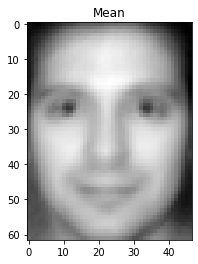

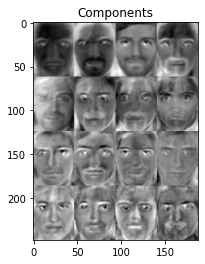

In [10]:
# check to see if the PCA components should be visualized
if args["visualize"] > 0:
	# initialize the list of images in the montage
	images = []

	# loop over the first 16 individual components
	for (i, component) in enumerate(pca.components_[:16]):
		# reshape the component to a 2D matrix, then convert the data
		# type to an unsigned 8-bit integer so it can be displayed
		# with OpenCV
		component = component.reshape((62, 47))
		component = rescale_intensity(component, out_range=(0, 255))
		component = np.dstack([component.astype("uint8")] * 3)
		images.append(component)

	# construct the montage for the images
	montage = build_montages(images, (47, 62), (4, 4))[0]

	# show the mean and principal component visualizations
	# show the mean image
	mean = pca.mean_.reshape((62, 47))
	mean = rescale_intensity(mean, out_range=(0, 255)).astype("uint8")
	plt_imshow("Mean", mean)
	plt_imshow("Components", montage)

In [11]:
# train a classifier on the eigenfaces representation
print("[INFO] training classifier...")
model = SVC(kernel="rbf", C=10.0, gamma=0.001, random_state=42)
model.fit(trainX, trainY)

# evaluate the model
print("[INFO] evaluating model...")
predictions = model.predict(pca.transform(testX))
print(classification_report(testY, predictions,
	target_names=le.classes_))

[INFO] training classifier...
[INFO] evaluating model...
              precision    recall  f1-score   support

     abraham       1.00      1.00      1.00         5
       allen       0.89      1.00      0.94         8
      carmen       1.00      1.00      1.00         5
      conrad       1.00      0.83      0.91         6
     cynthia       1.00      1.00      1.00         5
     darrell       1.00      1.00      1.00         5
       frank       1.00      1.00      1.00         5
      gloria       1.00      1.00      1.00         5
     jacques       1.00      1.00      1.00         6
        judy       1.00      1.00      1.00         5
       julie       0.83      1.00      0.91         5
     kenneth       1.00      0.83      0.91         6
         mae       1.00      1.00      1.00         5
     raymond       1.00      1.00      1.00         6
        rick       1.00      1.00      1.00         6
      sherry       1.00      1.00      1.00         6
     tiffany       1.00 

[INFO] prediction: gloria, actual: gloria


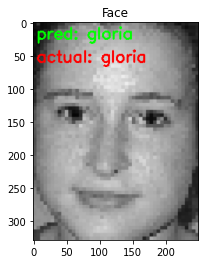

[INFO] prediction: sherry, actual: sherry


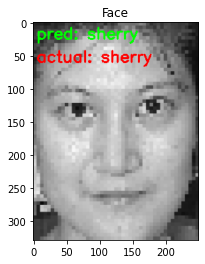

[INFO] prediction: judy, actual: judy


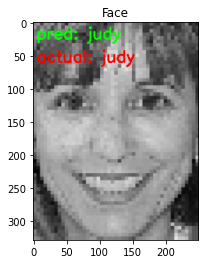

[INFO] prediction: willie, actual: willie


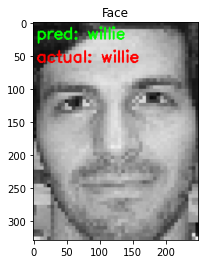

[INFO] prediction: frank, actual: frank


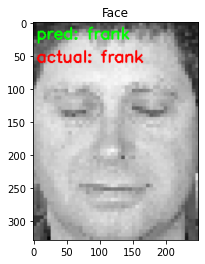

[INFO] prediction: darrell, actual: darrell


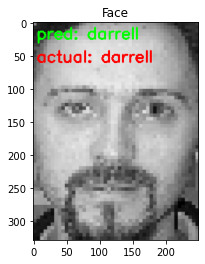

[INFO] prediction: julie, actual: kenneth


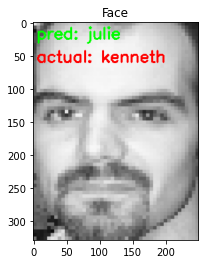

[INFO] prediction: frank, actual: frank


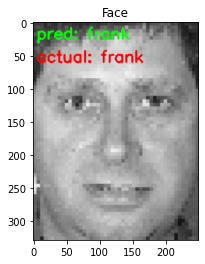

[INFO] prediction: conrad, actual: conrad


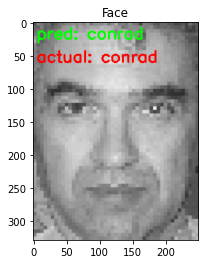

[INFO] prediction: tiffany, actual: tiffany


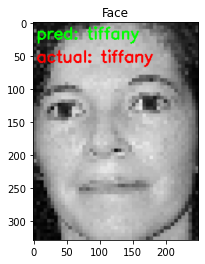

In [12]:
# generate a sample of testing data
idxs = np.random.choice(range(0, len(testY)), size=10, replace=False)

# loop over a sample of the testing data
for i in idxs:
	# grab the predicted name and actual name
	predName = le.inverse_transform([predictions[i]])[0]
	actualName = le.classes_[testY[i]]

	# grab the face image and resize it such that we can easily see
	# it on our screen
	face = np.dstack([origTest[i]] * 3)
	face = imutils.resize(face, width=250)

	# draw the predicted name and actual name on the image
	cv2.putText(face, "pred: {}".format(predName), (5, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
	cv2.putText(face, "actual: {}".format(actualName), (5, 60),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

	# display the predicted name  and actual name
	print("[INFO] prediction: {}, actual: {}".format(
		predName, actualName))

	# display the current face to our screen
	plt_imshow("Face", face)